<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

### **TAREA: Redes Recurrentes y Recursivas - Autoencoder**

*17 de Diciembre de 2024*

**Nombre Estudiante(s)**: 

### **1. Introducción**
Las redes neuronales recurrente (RNN), han demostrado ser especialmente útiles en la modelización de datos secuenciales debido a su capacidad de mantener una memoria temporal de los datos. Dentro de este contexto, las LSTM emergen como herramienta poderosa, capaces de capturar dependencias de largo plazo en las series temporales. Este informe presenta el ajuste de una arquitectura LSTM a dos conjuntos de datos distintos: la producción láctea y el índice IPSA de la bolsa de Santiago de Chile, con el objetivo de predecir valores futuros y proporcionar análisis descriptivos detallados.

Por otro lado, los autoencoders son una técnica de redes neuronales diseñada para aprender representaciones eficientes de los datos, típicamente para tareas de reducción de dimensionalidad o de limpieza de imágenes. En este informe, se explora la aplicación de un autoencoder para limpiar imágenes y extraer el texto contenido en ellas, utilizando una base de datos de Kaggle.


### **2. Objetivo**
- Predecir valores futuros y proporcionar análisis descriptivos detallados, con la arquitectura LSTM.

- Aplicar autoencoder para limpiar imágenes y extraer el texto contenido en ellas.

### **3. Metodología**
- Redes Neuronales Recurrentes LSTM (Long Short-Term Memory)
    * Lectura y pre-procesamiento del Conjunto de Datos.
    * Visualización 
- Perceptrón Multicapa para Clasificación de Imágenes
- Redes Neuronales Convolucionales
- Conclusiones

#### **Librerías requeridas**

In [21]:
# Importando Librerías
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

### **Redes Neuronales Recurrentes LSTM (Long Short-Term Memory)**
Tipo de arquitectura diseñada para manejar datos secuenciales, como series temporales, texto y audio.
-	Datos a estudiar:
1.	Datos de la producción láctea 
2.	Ipsa de la bolsa de Santiago 



### **1. Datos de Producción Láctea**

#### **Lectura y pre-procesamiento del Conjunto de Datos**

In [28]:
# Cargar el archivo CSV
df = pd.read_csv('data/monthly_milk_production.csv')

# Mostrar las primeras filas del DataFrame
df.head()


,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


La función .describe() nos ayuda a analizar los datos en profundidad.

In [18]:
df.describe().round(3)

,Production
count,168.000
mean,754.708
std,102.205
min,553.000
25%,677.750
50%,761.000
75%,824.500
max,969.000


Utilizando .isna().sum() podemos determinar los valores que faltan en el conjunto de datos. Parece que en el conjunto de datos no falta ningún valor.

In [19]:
df.isna().sum()

Date          0
Production    0
dtype: int64

#### **Visualización**
Se presenta la visualización de la información, la cual representa la producción lactante durante los años de 1962 al 1975.

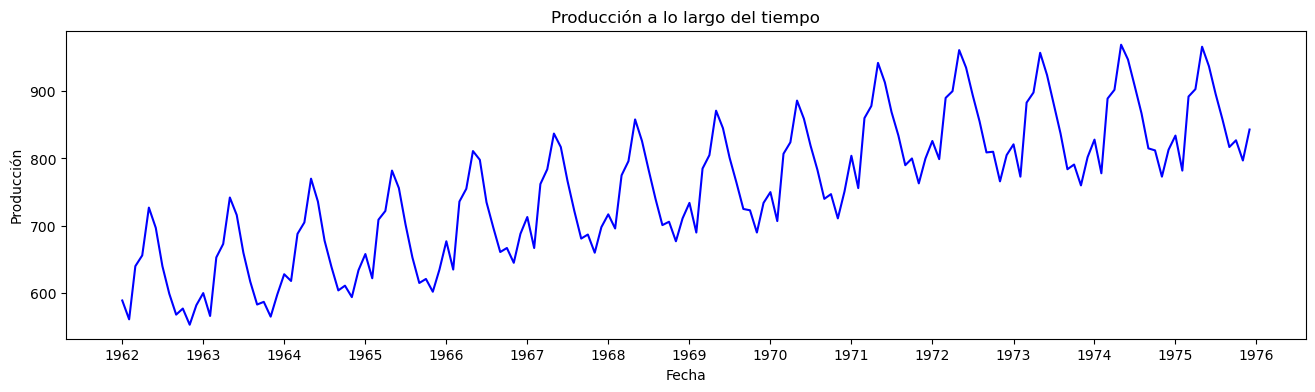

In [30]:
import matplotlib.dates as mdates


# Convertir la columna 'Date' a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Graficar los datos
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['Production'], linestyle='-', color='b')

# Formatear el eje X para que solo muestre los años
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Producción a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Producción')
plt.show()


#### **Redes Recursivas**

**split_percent: 0.8**, correspone a que el 80% de los datos se usarán de entrenamiento y el 20% de prueba.   
**Split:** Se calcula el índice de división para separa los datos de entrenamiento y prueba.

**MinMaxScaler:** Normalización de la data en un rango de 0 y 1.


In [39]:
# Función de procesamiento
def df_train_test(datos, split_percent = 0.8):
    data = datos['Production'].astype('float32').values # Converisón de los datos
    scaler = MinMaxScaler(feature_range=(0, 1)) # Normalización, rango 0,1
    data = scaler.fit_transform(data.reshape(-1, 1)).flatten() #Aplana aun array de una dimensión
    
    n = len(data) # Longitud de la data
    split = int(n*split_percent) #Calculo del índice de división 
    train_data = data[range(split)] # Datos de entrenamiento
    test_data = data[split:]    # Datos de prueba
    
    return train_data, test_data, data

In [ ]:
# Preparación del input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y

La funcion de preparación, prepara los datos de entrada X y los objetivos Y para la serie temporal.

In [41]:
def get_XY_multistep(dat, time_steps, forecast_steps):
    X, Y = [], []
    for i in range(len(dat) - time_steps - forecast_steps + 1):
        X.append(dat[i:(i + time_steps)])
        Y.append(dat[(i + time_steps):(i + time_steps + forecast_steps)])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


In [55]:
# Función del Modelo LSTM
def modelo_LSTM(hidden_units, dense_units, input_shape, activation):
    # Creación del Modelo Secuencial
    model = Sequential() 
    # Añadiendo la capa LSTM
    model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation))
    # Añadiendo una Capa Densa
    forecast_steps = 3
    model.add(Dense(units=forecast_steps))
    model.compile(optimizer="RMSprop", loss="mse")
    return model

In [58]:

def print_error(trainY, testY, train_predict, test_predict):
    # Aplanar las predicciones y los valores reales para que tengan la misma forma
    train_predict_flat = train_predict.flatten()
    trainY_flat = trainY.flatten()
    test_predict_flat = test_predict.flatten()
    testY_flat = testY.flatten()
    
    # Calcular el RMSE
    train_rmse = math.sqrt(mean_squared_error(trainY_flat, train_predict_flat))
    test_rmse = math.sqrt(mean_squared_error(testY_flat, test_predict_flat))
    
    # Imprimir el RMSE
    print('Train RMSE: {:.3f}'.format(train_rmse))
    print('Test RMSE: {:.3f}'.format(test_rmse))

 
# Visualización de Resultados
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predicción'])
    plt.xlabel('Número de observación después de intervalos de tiempo determinados')
    plt.ylabel('Escala')
    plt.title('Valores reales y previstos. La línea roja separa los ejemplos de entrenamiento y de prueba')

Epoch 1/50


c:\Users\crist\.conda\envs\proyecto\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.1737 - val_loss: 0.2329
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0580 - val_loss: 0.0478
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0218 - val_loss: 0.0320
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0232 - val_loss: 0.0405
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0214 - val_loss: 0.0520
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0241 - val_loss: 0.0392
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0208 - val_loss: 0.0379
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0190 - val_loss: 0.0213
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0239 - val_loss: 0.0333
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0205 - val_loss: 0.0213
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0207 - val_loss: 0.0568
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0203 - val_loss: 0.0234
Epoch 13/50

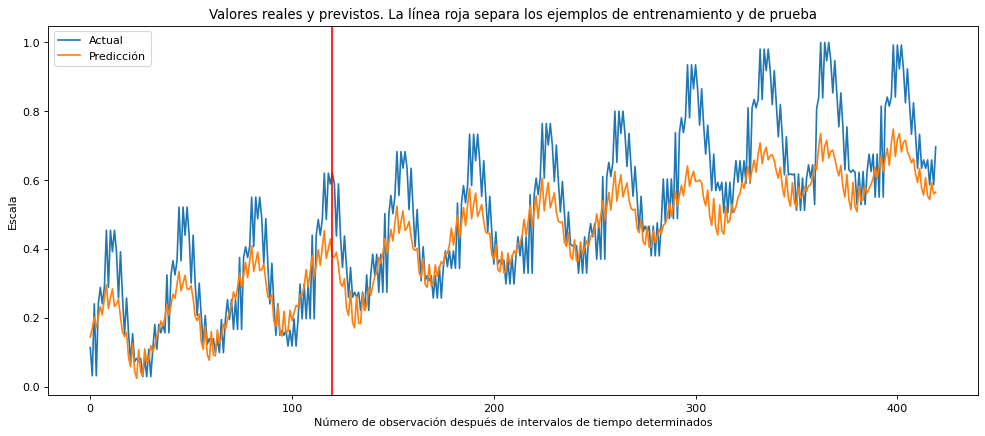

In [59]:
train_data, test_data, data = df_train_test(df)

time_steps = 12 
forecast_steps = 3 
# Preparar los datos
trainX, trainY = get_XY_multistep(train_data, time_steps, forecast_steps)
testX, testY = get_XY_multistep(test_data, time_steps, forecast_steps)

# Creación del modelo and train
model = modelo_LSTM(hidden_units=125, dense_units=1, input_shape=(time_steps,1), 
                   activation='tanh')
model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.2)

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

### **2. Ipsa de la bolsa de Santiago**
#### **Lectura y pre-procesamiento del Conjunto de Datos**

In [ ]:
# Cargar el archivo CSV
df_Ipsa = pd.read_csv('data/monthly_milk_production.csv')

# Mostrar las primeras filas del DataFrame
df_Ipsa.head()

.....

## **autoencoder o codificador automático**

#### **Librerías requeridas**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import zipfile
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.losses import MeanSquaredLogarithmicError


#### **Lectura y pre-procesamiento del Conjunto de Datos**

In [4]:
# Ruta del archivo ZIP 
zip_path_test = 'data/denoising-dirty-documents/test.zip' 
extract_path_test = 'data'
# Abre el archivo Zip
with zipfile.ZipFile(zip_path_test, 'r') as zip_ref: 
    zip_ref.extractall(extract_path_test)    
    
# Ruta del archivo ZIP 
zip_path_train = 'data/denoising-dirty-documents/train_cleaned.zip' 
extract_path_train = 'data'
# Abre el archivo Zip
with zipfile.ZipFile(zip_path_train, 'r') as zip_ref: 
    zip_ref.extractall(extract_path_train)  

# Rutas de los datos
train_dir = 'data/train_cleaned'
test_dir = 'data/test'

Normalización de los datos.

In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode='grayscale', target_size=(256, 256))
        img_array = img_to_array(img).astype('float32') / 255.
        images.append(img_array)
    return np.array(images)

# Cargar imágenes de entrenamiento y prueba
train_images = load_images_from_folder(train_dir)
test_images = load_images_from_folder(test_dir)

print('Tamaño de la imagen de entrenamiento:', train_images.shape)
print('Tamaño de la imagen de prueba:', test_images.shape)


Tamaño de la imagen de entrenamiento: (144, 256, 256, 1)
Tamaño de la imagen de prueba: (72, 256, 256, 1)


Esto significa que tienes 144 imágenes de entrenamiento y 72 imágenes de prueba, cada una con un tamaño de 256x256 píxeles en escala de grises (1 canal).

#### **Visualizando Imágenes**
Una excelente manera de ganar un entendimiento de los datos con los que estamos lidiando es mirando un par de ejemplos.

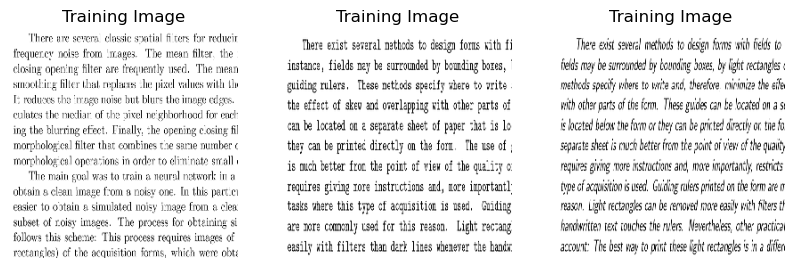

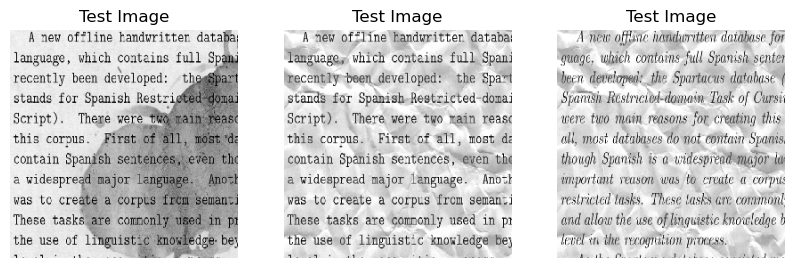

In [7]:
# Función de visualización
def show_img(imagen, titulo):
    n = 3 # Número de img para mostrar
    plt.figure(figsize=(10,10))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        idx = random.randint(0, imagen.shape[0] - 1)
        plt.imshow(imagen[idx].reshape(256, 256), cmap='gray')
        plt.title(titulo)
        plt.axis('off')
    plt.show()

# Mostrar imágenes de entrenamiento
show_img(train_images, "Training Image")

# Mostrar imágenes de prueba
show_img(test_images, "Test Image")


#### **Construcción del Autoencoder**
- El **Encoder (Codificador)** es una parte fundamental del Autoencoder. Su función principal es convertir los datos de entrada en una representación comprimida, conocida como la dimensión latente o "bottleneck".

- El **Decoder (Decodificador)** es la parte del Autoencoder responsable de reconstruir los datos de entrada a partir de la representación comprimida (dimensión latente) producida por el Encoder. La función principal del Decoder es expandir esta representación de menor dimensión a la forma original de los datos.

In [8]:
# Calcular el input_dim a partir de train_images
_, height, width, channels = train_images.shape
input_dim = height * width * channels

# Aplanar las imágenes para alimentar el Autoencoder
x_train_flat = train_images.reshape(-1, input_dim)
x_test_flat = test_images.reshape(-1, input_dim)

# Definir la capa de entrada
input_img = Input(shape=(input_dim,))

In [9]:
# Creación del modelo
class Autoencoder(Model):
    def __init__(self, input_dim, code_size=8):
        super().__init__()
        self.encoder = Sequential([
          Dense(128, activation='relu', input_shape=(input_dim,)),
          Dropout(0.1),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(32, activation='relu'),
          Dropout(0.1),  
          Dense(16, activation='relu'),
          Dropout(0.1), 
          Dense(code_size, activation='relu'),
        ])
        
        self.decoder = Sequential([
           Dense(16, activation='relu', input_shape=(code_size,)),
           Dropout(0.1),
           Dense(32, activation='relu'),
           Dropout(0.1), 
           Dense(64, activation='relu'),
           Dropout(0.1), 
           Dense(128, activation='relu'),
           Dense(input_dim, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_dim=input_dim)

c:\Users\crist\.conda\envs\proyecto\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Configuración de modelo
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Entrenar el modelo usando x_train como entrada y como destino. 

El modelo se entrena para que la salida sea lo más parecida posible a la entrada. En este caso, se intenta reconstruir x_train_flat a partir de x_train_flat.

- **shuffle=True**, los datos de entrenamiento se mezclan aleatoriamente antes de cada época. Esto ayuda a mejorar la generalización del modelo y evita patrones específicos en el orden de los datos que podrían afectar el entrenamiento.

In [21]:
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
# Definir early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(
    x_train_flat, # Conjunto de datos de entrenamiento aplanado
    x_train_flat,
    epochs=50,
    batch_size=100, # Tamaño
    shuffle=True,
    validation_data=(x_test_flat, x_test_flat), # evaluar el rendimiento del modelo
    callbacks=[early_stopping]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - loss: 0.0641 - val_loss: 0.0579
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - loss: 0.0642 - val_loss: 0.0580
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - loss: 0.0640 - val_loss: 0.0583
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 0.0639 - val_loss: 0.0583
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - loss: 0.0641 - val_loss: 0.0581
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 0.0638 - val_loss: 0.0579
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 0.0642 - val_loss: 0.0580
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - loss: 0.0641 - val_loss: 0.0584
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - loss: 0.0643 - val_loss: 0.0586
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - loss: 0.0641 - val_loss: 0.0584
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - loss: 0.0643 - val_loss: 0.0580


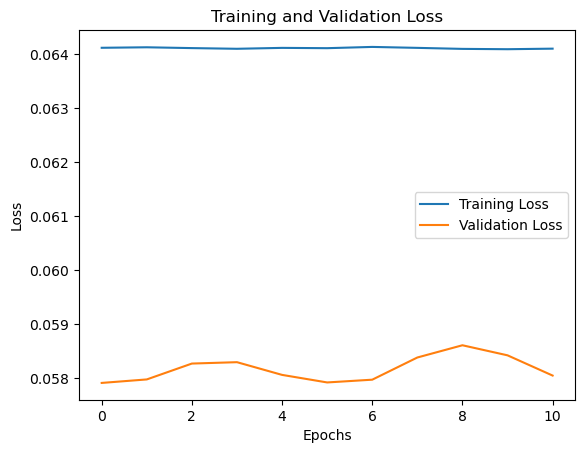

In [22]:
# Graficar pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### **Construcción del Autoencoder**
- El **Encoder (Codificador)** es una parte fundamental del Autoencoder. Su función principal es convertir los datos de entrada en una representación comprimida, conocida como la dimensión latente o "bottleneck".

- El **Decoder (Decodificador)** es la parte del Autoencoder responsable de reconstruir los datos de entrada a partir de la representación comprimida (dimensión latente) producida por el Encoder. La función principal del Decoder es expandir esta representación de menor dimensión a la forma original de los datos.

Ahora que el modelo está entrenado, se debe probar codificando y decodificando imágenes del conjunto de prueba.

In [23]:
encoded_imgs = autoencoder.encoder(x_test_flat).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

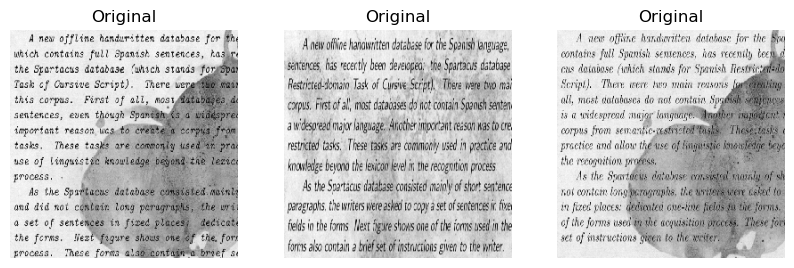

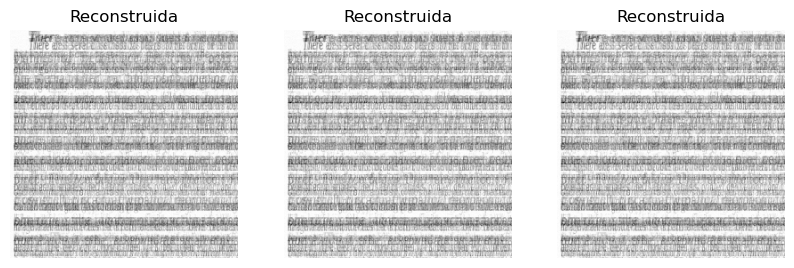

In [24]:
# Función de visualización
def show_img(imagen, titulo):
    n = 3 # Número de img para mostrar
    plt.figure(figsize=(10,10))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        idx = random.randint(0, imagen.shape[0] - 1)
        plt.imshow(imagen[idx].reshape(256, 256), cmap='gray')
        plt.title(titulo)
        plt.axis('off')
    plt.show()

# Mostrar imágenes original
show_img(x_test_flat, "Original")

# Mostrar Imágenes reconstruidas
show_img(decoded_imgs, "Reconstruida")



**Errores de Reconstrucción:**
Calcular las métricas como el error cuadrático medio (MSE) o el error absoluto medio (MAE) en el conjunto de prueba.

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

reconstructions = autoencoder.predict(x_test_flat)
mse = mean_squared_error(x_test_flat, reconstructions)
mae = mean_absolute_error(x_test_flat, reconstructions)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
MSE: 0.0579, MAE: 0.1630
